# Install Libraries

In [35]:
!pip install dask[dataframe] protobuf==3.20.*

In [1]:
#Install the necessary libraries for forecasting
!pip install statsforecast mlforecast neuralforecast nixtla

Importing Libraries Required for this Notebook

In [3]:
from nixtla import NixtlaClient
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import AutoTBATS, AutoARIMA, AutoETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast.target_transforms import AutoDifferences
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT, NHITS
from neuralforecast.losses.pytorch import MAE
from nixtla import NixtlaClient
from functools import reduce
#import timesfm

# Data Preparation

In [4]:
data = pd.read_excel("monthly_data.xlsx")

In [5]:
data.head()

,date,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,2020-12-01,Prague_1,190208,Christmas Eve2nd Christmas Day,2,0,0,1,0,0,0,0,0,8.3,0.0,45470,839751,Prague_1_2020-12-05Prague_1_2020-12-06Prague_1...
1,2021-01-01,Prague_1,235089,New Years Day,1,0,0,1,0,0,0,0,0,166.3,112.0,53790,996212,Prague_1_2021-01-01Prague_1_2021-01-02Prague_1...
2,2021-02-01,Prague_1,222102,0,0,0,0,0,0,0,0,0,0,37.0,134.0,49832,943849,Prague_1_2021-02-01Prague_1_2021-02-02Prague_1...
3,2021-03-01,Prague_1,254258,International womens day,0,0,0,0,14,0,0,0,0,24.9,3.0,55508,1094886,Prague_1_2021-03-01Prague_1_2021-03-02Prague_1...
4,2021-04-01,Prague_1,242598,Good FridayEaster Monday,4,0,0,1,0,0,0,0,0,13.4,2.0,50988,1041067,Prague_1_2021-04-01Prague_1_2021-04-02Prague_1...


In [6]:
data.columns

Index(['date', 'warehouse', 'orders', 'holiday_name', 'holiday', 'shutdown',
       'mini_shutdown', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'id'],
      dtype='object')

## Dropping the columns that wont be known in advance.

In [7]:
data = data.drop(["holiday_name", 'shutdown', 'mini_shutdown', 'blackout', 'frankfurt_shutdown', "id", 'blackout', 'mov_change', 'frankfurt_shutdown','precipitation', 'snow', 'user_activity_1', 'user_activity_2'], axis=1)

In [8]:
#rename as per requirement of the forecast libraries
data = data.rename(columns={"warehouse": "unique_id", "date": "ds", "orders": "y"})

In [9]:
data.head()

,ds,unique_id,y,holiday,shops_closed,winter_school_holidays,school_holidays
0,2020-12-01,Prague_1,190208,2,1,0,0
1,2021-01-01,Prague_1,235089,1,1,0,0
2,2021-02-01,Prague_1,222102,0,0,0,0
3,2021-03-01,Prague_1,254258,0,0,14,0
4,2021-04-01,Prague_1,242598,4,1,0,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ds                      160 non-null    datetime64[ns]
 1   unique_id               160 non-null    object        
 2   y                       160 non-null    int64         
 3   holiday                 160 non-null    int64         
 4   shops_closed            160 non-null    int64         
 5   winter_school_holidays  160 non-null    int64         
 6   school_holidays         160 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 8.9+ KB


In [11]:
data['ds'] = pd.to_datetime(data['ds'])

In [12]:
#Splitting the Data for Trasin & Test
train = data[data['ds'] <= '2023-07-01']
test = data[data['ds'] > '2023-07-01']

In [13]:
train.groupby('unique_id')['y'].count()

,y
unique_id,
Brno_1,32
Prague_1,32
Prague_2,32
Prague_3,32


In [14]:
train.head()

,ds,unique_id,y,holiday,shops_closed,winter_school_holidays,school_holidays
0,2020-12-01,Prague_1,190208,2,1,0,0
1,2021-01-01,Prague_1,235089,1,1,0,0
2,2021-02-01,Prague_1,222102,0,0,0,0
3,2021-03-01,Prague_1,254258,0,0,14,0
4,2021-04-01,Prague_1,242598,4,1,0,0


# SFFORECAST

###Defining Statforecast Parameters

In [15]:
models = [AutoARIMA(season_length=12)]

sf = StatsForecast(models=models, freq='MS', n_jobs=1)

In [16]:
test_ = test.drop("y", axis=1)

In [17]:
horizon = 8
sf_fcst = sf.forecast(df=train, h=horizon, X_df=test_)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [18]:
sf_fcst.head()

,ds,AutoARIMA
unique_id,,
Brno_1,2023-08-01,222424.500000
Brno_1,2023-09-01,229416.265625
Brno_1,2023-10-01,229416.265625
Brno_1,2023-11-01,220278.250000
Brno_1,2023-12-01,227270.015625


### Defining AutoTBATS & AutoETS

In [19]:
models = [AutoTBATS(season_length=12),AutoETS(season_length=12)]

In [20]:
stat_fcst = StatsForecast(models=models,freq='MS')

In [21]:
train_stat_df_ETS_TBATS = train[["unique_id", "ds", "y"]]

In [22]:
ets_tbats = stat_fcst.forecast(df=train_stat_df_ETS_TBATS, h=horizon)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [23]:
ets_tbats.head()

,ds,AutoTBATS,AutoETS
unique_id,,,
Brno_1,2023-08-01,209069.531250,218065.5
Brno_1,2023-09-01,211692.437500,218065.5
Brno_1,2023-10-01,216360.843750,218065.5
Brno_1,2023-11-01,221846.328125,218065.5
Brno_1,2023-12-01,226698.718750,218065.5


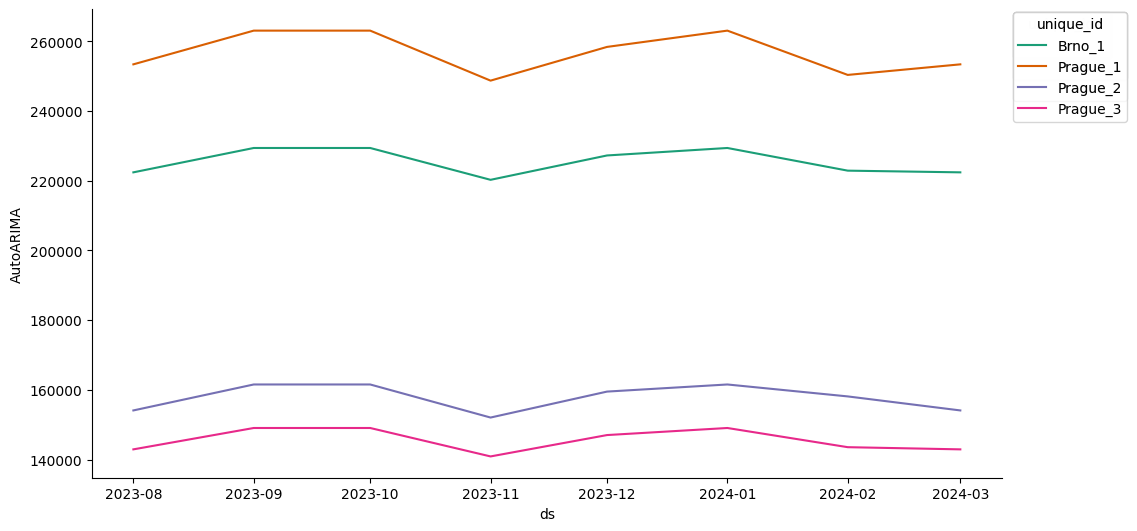

In [24]:
# @title ds vs AutoARIMA

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['AutoARIMA']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sf_fcst.sort_values('ds', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('unique_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='unique_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('AutoARIMA')

# MLForecast

In [25]:
models = [LinearRegression(),
    lgb.LGBMRegressor(verbosity=-1),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]
@njit
def rolling_mean_3(x):
    return rolling_mean(x, window_size=3)
@njit
def rolling_mean_6(x):
    return rolling_mean(x, window_size=6)

mlf = MLForecast(
    models=models,
    freq='MS',
    lags=[1,3,5,7,12],

    lag_transforms={
        1: [expanding_mean],
        3: [rolling_mean_3, rolling_mean_6],
        5: [rolling_mean_3, rolling_mean_6],
        7: [rolling_mean_3, rolling_mean_6],
        12: [rolling_mean_3, rolling_mean_6],
    },
    date_features=['year', 'month', 'day', 'quarter'],
    target_transforms=[AutoDifferences(max_diffs=2)])


In [26]:
mlf.fit(
    train,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=[]
)

MLForecast(models=[LinearRegression, LGBMRegressor, XGBRegressor, RandomForestRegressor], freq=MS, lag_features=['lag1', 'lag3', 'lag5', 'lag7', 'lag12', 'expanding_mean_lag1', 'rolling_mean_3_lag3', 'rolling_mean_6_lag3', 'rolling_mean_3_lag5', 'rolling_mean_6_lag5', 'rolling_mean_3_lag7', 'rolling_mean_6_lag7', 'rolling_mean_3_lag12', 'rolling_mean_6_lag12'], date_features=['year', 'month', 'day', 'quarter'], num_threads=1)

In [27]:
#For using in predict function
future_df = test[["unique_id", "ds", 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']]

In [28]:
mlforecast = mlf.predict(horizon, X_df=future_df)

In [29]:
mlforecast.head()

,unique_id,ds,LinearRegression,LGBMRegressor,XGBRegressor,RandomForestRegressor
0,Brno_1,2023-08-01,227190.437500,228725.968750,233442.093750,224020.109375
1,Brno_1,2023-09-01,235045.265625,233270.750000,227929.968750,229621.281250
2,Brno_1,2023-10-01,229778.421875,238963.562500,229907.171875,232178.718750
3,Brno_1,2023-11-01,236426.859375,233743.015625,219386.390625,231901.265625
4,Brno_1,2023-12-01,270286.625000,244559.890625,235789.875000,242386.671875


# Neural Forecast

In [30]:
hist_exog_list = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

horizon = len(test)  # Number of future time steps to predict
# Initialize the TFT model
tft_model = TFT(h=8,  # Forecasting horizon of 12 months
                input_size=32,  # Assuming we use 12 months of history
                hist_exog_list=hist_exog_list,
                max_steps=200,
                start_padding_enabled=True,
                loss=MAE())

# Initialize the NHITS model
nhits_model = NHITS(h=8,  # Forecasting horizon of 12 months
                input_size=32,  # Assuming we use 12 months of history
                hist_exog_list=hist_exog_list,
                max_steps=200,
                start_padding_enabled=True,
                loss=MAE())

INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [31]:
nf = NeuralForecast(models=[tft_model, nhits_model], freq='MS')  # 'M' for monthly frequency

nf.fit(df=train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
2024-09-12 05:02:09.705265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-09-12 05:02:09.705349: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | Constant

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.343    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.


In [33]:
neural_fcst = nf.predict(futr_df = future_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [34]:
neural_fcst.head()

,ds,TFT,NHITS
unique_id,,,
Brno_1,2023-08-01,216441.187500,221132.906250
Brno_1,2023-09-01,216305.250000,209364.734375
Brno_1,2023-10-01,220053.093750,207308.046875
Brno_1,2023-11-01,222755.890625,201465.671875
Brno_1,2023-12-01,228693.828125,226046.234375


# TimeGPT

In [35]:

# Initialize the NixtlaClient
nixtla_client = NixtlaClient(api_key='Your_API_Key')

# Assuming df is your input dataframe with historical data
# and future_df is your dataframe with future exogenous variables

# Specify the exogenous variables
exog_vars = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
# Make the forecast
timegpt_fcst_zero = nixtla_client.forecast(df=train, h=8, X_df=future_df, freq='MS')


In [36]:
timegpt_fcst_zero['ds'] = pd.to_datetime(timegpt_fcst_zero['ds'])

In [37]:
timegpt_fcst_zero.head()

,unique_id,ds,TimeGPT
0,Brno_1,2023-08-01,220455.67
1,Brno_1,2023-09-01,228034.19
2,Brno_1,2023-10-01,230253.77
3,Brno_1,2023-11-01,230474.08
4,Brno_1,2023-12-01,233315.88


## Timesfm

In [ ]:
# Y_test_df = test.copy()
# df = train.copy()

In [ ]:
# tfm = timesfm.TimesFm(
#     context_len=512,
#     horizon_len=8,
#     input_patch_len=32,
#     output_patch_len=128,
#     num_layers=20,
#     model_dims=1280,
#     backend="cpu",
# )
# tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

In [ ]:
# timesfm_df = tfm.forecast_on_df(
#     inputs=df,
#     freq='MS',
#     value_name='y',
#     num_jobs=-1,
# )

In [42]:
timesfm_df = pd.read_csv("timesfm_monthly.csv")

In [47]:
timesfm_df['ds'] = pd.to_datetime(timesfm_df['ds'])

In [48]:
#Merge All Results
data_frames = [sf_fcst, ets_tbats,mlforecast, neural_fcst,timegpt_fcst_zero,timesfm_df ]
final_forecast_monthly_merged = reduce(lambda  left,right: pd.merge(left,right,on=['unique_id', 'ds'],how='inner'), data_frames)

In [49]:
final_forecast_monthly_merged.to_csv("final_forecast_monthly_merged.csv")